# Метрики precision и recall

Данные содержат признаки пользователей и целевую переменную affair - была ли связь на стороне

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

parameters = {
    'axes.labelsize':  14,
    'figure.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
}
plt.rcParams.update(parameters)

In [2]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


In [4]:
from sklearn.linear_model import LogisticRegression

# импортируем метод для автоматической разбивки на обучающую и тестовую выборки
# раньше использовали from sklearn.cross_validation import train_test_split  
from sklearn.model_selection import train_test_split

Формируем набор признаков и целевую переменную

In [5]:
X = data[data.columns[:-1]]
Y = data['affair']

Разбиваем данные на обучающую и тестовую выборки в соотношении 70 / 30

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

Обучаем модель

In [7]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

Получаем прогнозные значения модели (переменная predictions)

In [8]:
predictions = model.predict_proba(X_test)

## Оценка качества модели

In [9]:
y_predicted = model.predict_proba(X_test)

def rightness_matrix(predictions, test, threshold=0.5):
    """Считает количество правильно и ошибочно предсказанных
       значений, в разрезе по классам."""
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip(predictions, test):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    return tp, fp, tn, fn

## Точность

In [10]:
tp, fp, tn, fn = rightness_matrix(predictions[:, 1], Y_test)
# какая точность получилась?
(tp + tn) / (tp + fp + fn + tn)

0.7319371727748691

In [11]:
# средствами sklearn
model.score(X_test, Y_test)

0.7319371727748691

### ROC (Receiver Operating Characteristic)

Кривая в координатах false_positive_rate и true_positive_rate.

In [12]:
def false_positive_rate(tp, fp, tn, fn):
    return fp / (fp + tn)

def true_positive_rate(tp, fp, tn, fn):
    return tp / (tp + fn)

In [13]:
xx = []
yy = []
for i in np.linspace(0, 1, num=1000):
    m = rightness_matrix(predictions[:, 1], Y_test, threshold=i)
    xx.append(false_positive_rate(*m))
    yy.append(true_positive_rate(*m))

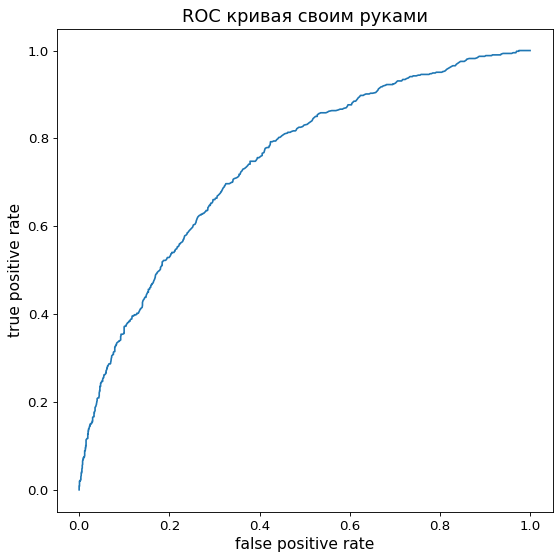

In [14]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.title('ROC кривая своим руками')
plt.plot(xx, yy)
_ = plt.xlabel("false positive rate")
_ = plt.ylabel("true positive rate")

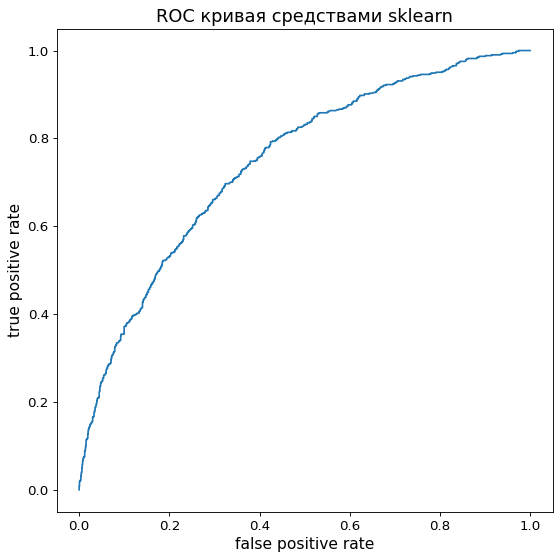

In [15]:
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.title('ROC кривая средствами sklearn')
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )
plt.plot( fpr, tpr)
_ = plt.xlabel("false positive rate")
_ = plt.ylabel("true positive rate")

In [16]:
# auc своими руками
a = []
for i in range(len(yy)-1):
    a.append(xx[i] * (yy[i] - yy[i+1]))
1 - np.sum(a)

0.7444510892996898

In [17]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.7451629176618145

## Precision - Recall

In [18]:
def precision(tp, fp, tn, fn):
    return tp / (tp + fp)

def recall(tp, fp, tn, fn):
    return tp / (tp + fn)

In [19]:
xx = []
yy = []
for i in np.linspace(0, 1, num=1000):
    m = rightness_matrix(predictions[:, 1], Y_test, threshold=i)
    try:
        xx.append(precision(*m))
        yy.append(recall(*m))
    except ZeroDivisionError:
        pass

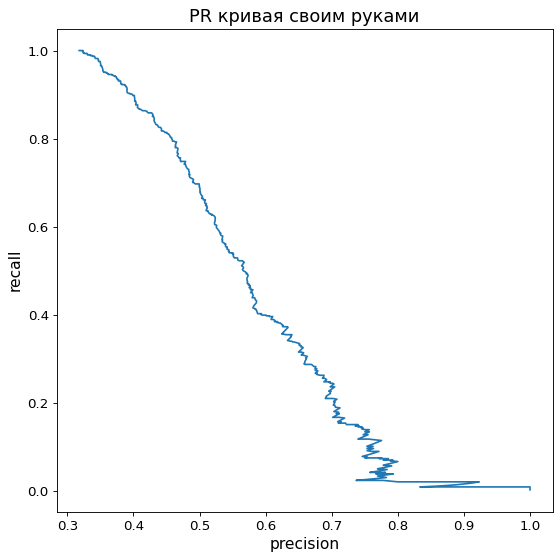

In [20]:
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.title('PR кривая своим руками')
plt.plot(xx, yy)
_ = plt.xlabel("precision")
_ = plt.ylabel("recall")

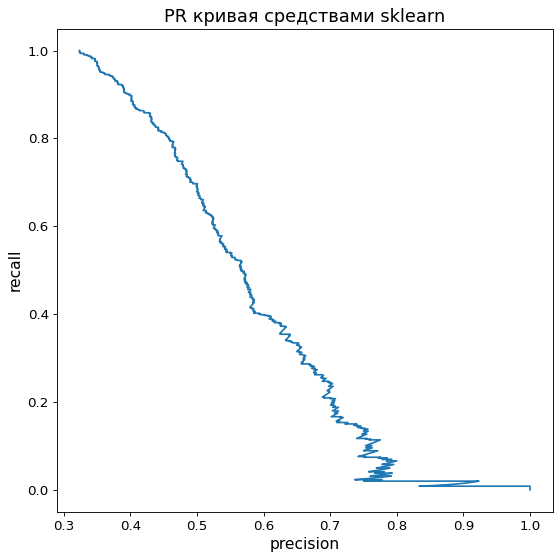

In [21]:
from sklearn.metrics import precision_recall_curve
fig = plt.figure(figsize=(8, 8), dpi=80)
plt.title('PR кривая средствами sklearn')
pr, re, thres = precision_recall_curve( Y_test, predictions[:, 1] )
plt.plot(pr, re)
_ = plt.xlabel("precision")
_ = plt.ylabel("recall")

In [22]:
# auc своими руками
a = []
for i in range(len(yy)-1):
    a.append(xx[i] * (yy[i] - yy[i+1]))

np.sum(a)

0.5742084635460852

In [23]:
# auc средствами sklearn
auc(re, pr)

0.5754162314241495